# **Imports and Dependencies**

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2, pathlib
from google.colab import files

In [ ]:
KEYPOINT_EDGES = [
    (0, 1),
    (0, 2),
    (1, 3),
    (2, 4),
    (0, 5),
    (0, 6),
    (5, 7),
    (7, 9),
    (6, 8),
    (8, 10),
    (5, 6),
    (5, 11),
    (6, 12),
    (11, 12),
    (11, 13),
    (13, 15),
    (12, 14),
    (14, 16)
]

# **Data Preprocessing**

In [ ]:
df = pd.read_csv("keypoints_data.csv")
df.head()

,noseX,noseY,left_eyeX,left_eyeY,right_eyeX,right_eyeY,left_earX,left_earY,right_earX,right_earY,...,right_hipY,left_kneeX,left_kneeY,right_kneeX,right_kneeY,left_ankleX,left_ankleY,right_ankleX,right_ankleY,exercise
0,0.539241,0.562888,0.555527,0.561902,0.529999,0.558287,0.574060,0.531854,0.502490,0.526930,...,0.421526,0.608265,0.571625,0.495987,0.584337,0.537182,0.693354,0.515442,0.694399,0
1,0.256339,0.555525,0.245591,0.542631,0.246213,0.538990,0.251576,0.498928,0.248534,0.489597,...,0.483305,0.768328,0.639089,0.774396,0.621811,0.948640,0.739688,0.940743,0.726468,0
2,0.539357,0.690845,0.555154,0.703071,0.523741,0.697469,0.579763,0.676099,0.498116,0.666432,...,0.470383,0.576357,0.609860,0.473827,0.595566,0.537077,0.705968,0.435812,0.735543,0
3,0.543826,0.776397,0.563946,0.782749,0.533213,0.780279,0.588520,0.754564,0.501276,0.742542,...,0.522356,0.537980,0.573046,0.482752,0.574605,0.683411,0.762736,0.402634,0.757211,0
4,0.543992,0.780590,0.560737,0.788503,0.530577,0.787271,0.587577,0.760645,0.496612,0.746140,...,0.519301,0.548825,0.568235,0.461435,0.600380,0.540867,0.599851,0.502858,0.617974,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1343 entries, 0 to 1342
Data columns (total 35 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   noseX            1343 non-null   float64
 1   noseY            1343 non-null   float64
 2   left_eyeX        1343 non-null   float64
 3   left_eyeY        1343 non-null   float64
 4   right_eyeX       1343 non-null   float64
 5   right_eyeY       1343 non-null   float64
 6   left_earX        1343 non-null   float64
 7   left_earY        1343 non-null   float64
 8   right_earX       1343 non-null   float64
 9   right_earY       1343 non-null   float64
 10  left_shoulderX   1343 non-null   float64
 11  left_shoulderY   1343 non-null   float64
 12  right_shoulderX  1343 non-null   float64
 13  right_shoulderY  1343 non-null   float64
 14  left_elbowX      1343 non-null   float64
 15  left_elbowY      1343 non-null   float64
 16  right_elbowX     1343 non-null   float64
 17  right_elbowY  

Split dataset into train and validation sets

In [ ]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state=420)

print(X_train)
print(y_train)
print(X_val)
print(y_val)

         noseX     noseY  left_eyeX  left_eyeY  right_eyeX  right_eyeY  \
715   0.470746  0.365668   0.473252   0.352121    0.467526    0.354558   
1039  0.498495  0.232756   0.496011   0.219038    0.494417    0.219626   
356   0.292468  0.412111   0.291213   0.388220    0.289374    0.394430   
307   0.725959  0.417009   0.734201   0.407230    0.728970    0.398214   
472   0.526853  0.763519   0.508584   0.765417    0.561460    0.749324   
...        ...       ...        ...        ...         ...         ...   
799   0.396391  0.380018   0.404836   0.360707    0.393653    0.363077   
575   0.264159  0.528631   0.248735   0.517414    0.246885    0.514527   
390   0.197454  0.521350   0.199203   0.496156    0.192287    0.497687   
1096  0.455318  0.217407   0.476576   0.200662    0.429020    0.201641   
945   0.500824  0.178994   0.517378   0.160789    0.487140    0.161537   

      left_earX  left_earY  right_earX  right_earY  ...  right_hipX  \
715    0.494753   0.349287    0.476160  

# **Initialize the Base Model (in consideration of improving the model later on)**

In [ ]:
def base_model():
  input = Input(shape=(34,), name="base_input")
  x = Flatten()(input)
  x = Dense(128, activation="relu", name="first_dense")(x)
  x = Dropout(0.3)(x)
  x = Dense(64, activation="relu", name="second_dense")(x)
  x = Dropout(0.2)(x)
  x = Dense(32, activation="relu", name="third_dense")(x)
  x = Dropout(0.1)(x)
  x = Dense(1, activation="sigmoid", name="base_output")(x)
  return Model(inputs=input, outputs=x)

Plot the model

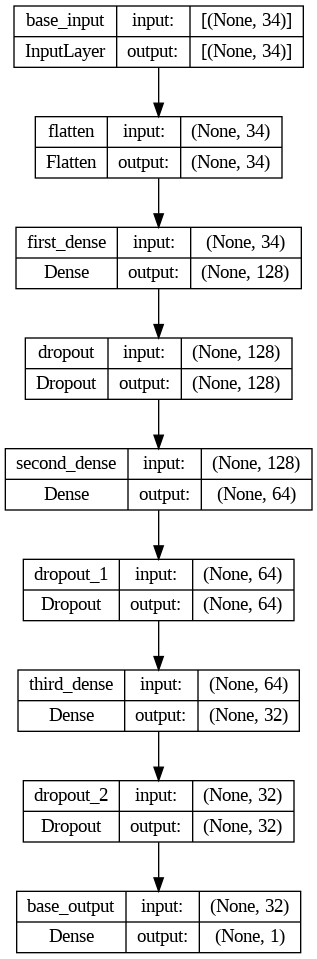

In [ ]:
model = base_model()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='base-model.png')

Compile and train the model

In [ ]:
model.compile(
    optimizer = "adam",
    loss = "binary_crossentropy",
    metrics = ["accuracy"]
  )

model.summary()

history = model.fit(
    X_train,
    y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val)
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 base_input (InputLayer)     [(None, 34)]              0         
                                                                 
 flatten (Flatten)           (None, 34)                0         
                                                                 
 first_dense (Dense)         (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 second_dense (Dense)        (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 third_dense (Dense)         (None, 32)                2080  

Plot the accuracy per epoch

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

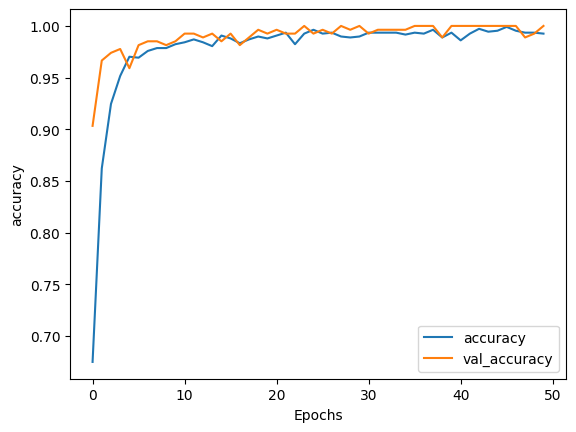

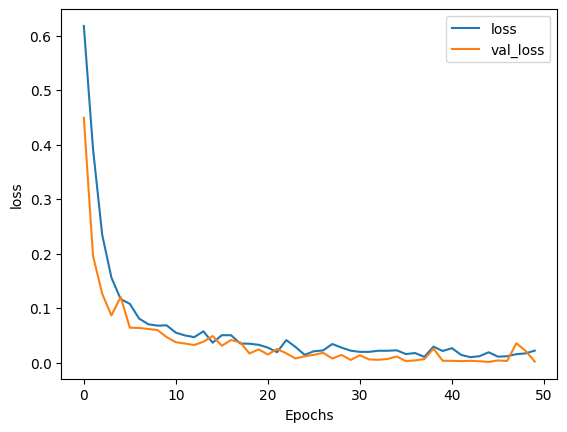

In [ ]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

# **Start Predicting Real Keypoints From Images**

Load MoveNet Lightning Model

In [ ]:
movenet_model = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")

In [ ]:
def predict_keypoints(model, image_path):
    # Read image files and rersize it to 192x192
    image = tf.io.read_file(image_path)
    image = tf.compat.v1.image.decode_jpeg(image)
    image = tf.expand_dims(image, axis=0)
    image = tf.cast(tf.image.resize_with_pad(image, 192, 192), dtype=tf.int32)

    # Predict using movenet
    movenet = model.signatures["serving_default"]
    outputs = movenet(image)

    # Return keypoints in (1, 1, 17, 3)
    keypoints = outputs["output_0"]

    return image, keypoints

Display Keypoints

In [ ]:
from google.colab.patches import cv2_imshow

def display_keypoints(input_image, keypoints, width=512, height=512):
    input_image = tf.image.resize_with_pad(input_image, width, height)
    input_image = tf.cast(input_image, dtype=tf.uint8)

    npy_image = np.squeeze(input_image.numpy(), axis=0)
    npy_image = cv2.resize(npy_image, (width, height))
    npy_image = cv2.cvtColor(npy_image, cv2.COLOR_RGB2BGR)

    for keypoint in keypoints[0][0]:
        x = int(keypoint[1] * width)
        y = int(keypoint[0] * height)
        cv2.circle(npy_image, (x, y), 4, (0, 255, 255), -1)

    for edge in KEYPOINT_EDGES:
        x1 = int(keypoints[0][0][edge[0]][1] * width)
        y1 = int(keypoints[0][0][edge[0]][0] * height)
        x2 = int(keypoints[0][0][edge[1]][1] * width)
        y2 = int(keypoints[0][0][edge[1]][0] * height)
        cv2.line(npy_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    cv2_imshow(npy_image)
    cv2.waitKey()

### **if 1 = squat and if 0 = pushup**

Predict pushup and squat images

In [ ]:
image_data = [
    "pushup1.jpg",
    "pushup2.jpg",
    "pushup3.jpg",
    "squat1.jpg",
    "squat2.jpg",
    "squat3.jpg"
    ]

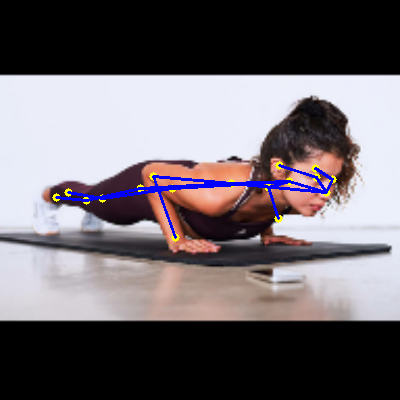

1/1 [==============================] - 0s 36ms/step
pushup gan ([[2.9161342e-06]])



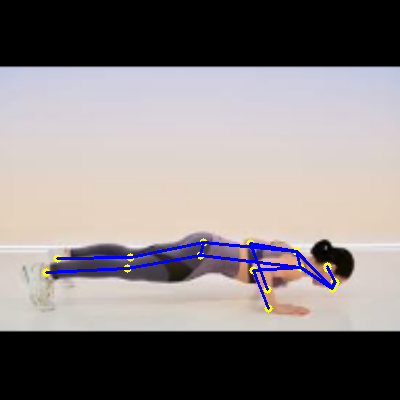

1/1 [==============================] - 0s 39ms/step
pushup gan ([[1.035463e-05]])



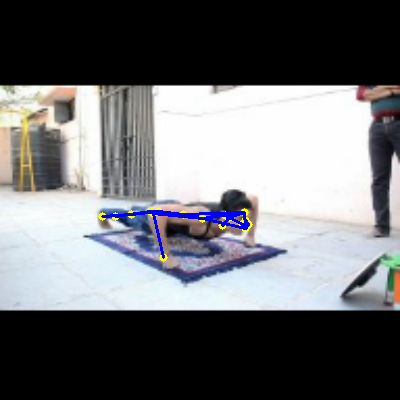

1/1 [==============================] - 0s 42ms/step
pushup gan ([[0.00044286]])



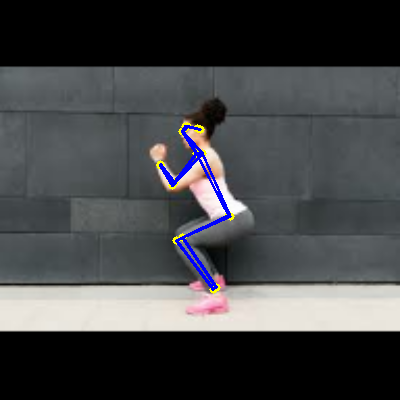

1/1 [==============================] - 0s 39ms/step
anjay squat ([[0.9996026]])


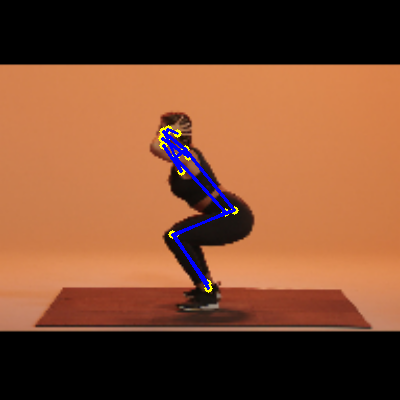

1/1 [==============================] - 0s 42ms/step
anjay squat ([[0.9998046]])


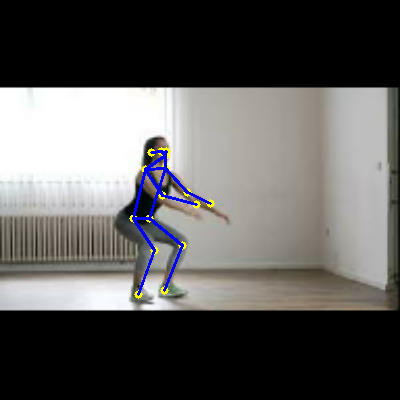

1/1 [==============================] - 0s 39ms/step
anjay squat ([[0.99810505]])


In [ ]:
for img in image_data:
  input_image, keypoints = predict_keypoints(movenet_model, img)
  data_temp = []
  for keypoint in keypoints[0][0]:
            x = float(keypoint[1].numpy())
            y = float(keypoint[0].numpy())
            data_temp.append(x)
            data_temp.append(y)

  display_keypoints(input_image, keypoints, 400, 400)

  # Predict pose according to keypoints data
  data_temp = tf.reshape(data_temp, shape=(-1, 34))
  predick = model.predict(data_temp)
  print("anjay squat ({})".format(predick) if predick > 0.5 else "pushup gan ({})\n".format(predick))

# **Save Model**

Save model in saved model format

In [ ]:
export_dir = "saved_model/v1"

In [ ]:
tf.saved_model.save(model, export_dir)

Save model in hdf5 format

In [ ]:
# model.save("pose_model.h5")

Save model in pickle format

In [ ]:
# import pickle
# with open("pose_model.pkl", "wb") as f:
#     pickle.dump(model, f)

Save model in tflite format

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('./pose_model.tflite')
tflite_model_file.write_bytes(tflite_model)

18528

In [ ]:
files.download(tflite_model_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>